In [1]:
import time
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install ipython

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.display_functions import clear_output
from IPython.display import display

import os
import math

In [3]:
species_values = ['Iris-setosa','Iris-versicolor','Iris-virginica']

In [4]:
def sigmoid(logit): # sigmoid
  return 1/(1+ np.exp(-logit))

def softmax(logit): # softmax
  return np.exp(logit)/np.sum(np.exp(logit))

def tan_h(logit): # tanh
  return np.tanh(logit)

In [5]:


def update_graphs(): 
    bad_facts_ln.set_data(range(len(bad_facts_per_epoch)),bad_facts_per_epoch)
    bad_facts_fig.gca().relim()
    bad_facts_fig.gca().autoscale_view()
    
    clear_output(wait=True)
    display(bad_facts_fig)

In [6]:

layer0_size = None
layer1_size = None
layer2_size = None

layer_1_dropout = None

layer0_outputs = None
layer1_outputs = None
layer2_outputs = None

layer1_logit = None
layer2_logit = None

layer1_weights = None
layer2_weights = None

layer2_delta = None
layer1_delta = None

update_graph_live = None
update_graph_intervals = None

error_threshold = None
learning_rate = None
layer_1_dropout_prob = None

layer1_activation_function = None
layer2_activation_function = None

bad_facts_per_epoch = None

bad_facts_fig = None
bad_facts_ax = None
bad_facts_ln = None

training_data = None
testing_data = None
all_data = None

shuffle_seed = None
seed = None

def init(p_seed = 42, layer0_size=4, layer1_size=4, layer2_size=3, p_update_graph_live=True, p_update_graph_intervals=50, p_error_threshold=0.2, p_learning_rate=0.2, p_layer_1_dropout_prob=0.0, p_layer1_activation_function="sigmoid", p_layer2_activation_function="softmax"):
    global layer_1_dropout, layer0_outputs, layer1_outputs, layer2_outputs
    global layer1_logit, layer2_logit
    global layer1_weights, layer2_weights
    global layer2_delta, layer1_delta
    global bad_facts_per_epoch
    global update_graph_live, update_graph_intervals
    global error_threshold, learning_rate, layer_1_dropout_prob
    global layer1_activation_function, layer2_activation_function
    global bad_facts_fig, bad_facts_ax, bad_facts_ln
    global shuffle_seed,seed
    
        
    seed = p_seed
    np.random.seed(p_seed)
    shuffle_seed = np.random.randint(0,1000000)

    layer_1_dropout = np.zeros(layer1_size)

    layer0_outputs = np.zeros(layer0_size)
    layer1_outputs = np.zeros(layer1_size)
    layer2_outputs = np.zeros(layer2_size)

    layer1_logit = np.zeros(layer1_size)
    layer2_logit = np.zeros(layer2_size)

    layer1_weights = np.random.uniform(-1,1,size=(layer0_size,layer1_size))
    layer2_weights = np.random.uniform(-1,1,size=(layer1_size,layer2_size))

    layer2_delta = np.zeros(layer2_size)
    layer1_delta = np.zeros(layer1_size)

    bad_facts_per_epoch = []

    update_graph_live = p_update_graph_live
    update_graph_intervals = p_update_graph_intervals
    error_threshold = p_error_threshold
    learning_rate = p_learning_rate
    layer_1_dropout_prob = p_layer_1_dropout_prob
    layer1_activation_function = p_layer1_activation_function
    layer2_activation_function = p_layer2_activation_function

    bad_facts_fig, bad_facts_ax = plt.subplots()
    bad_facts_ln, = bad_facts_ax.plot([], [], label='Bad Facts')

    bad_facts_ax.set_xlabel('Epoch')
    bad_facts_ax.set_ylabel('Bad Facts')
    bad_facts_ax.legend(loc='upper right')
    bad_facts_ax.set_title('Bad Facts per Epoch')
    
    def read_data():

        global training_data, testing_data, all_data

        all_data = pd.read_csv("iris.csv")
        all_data = all_data.sample( frac=1, random_state=shuffle_seed) # shuffle
        for species_value in species_values:
            all_data['Species_' + species_value] = (all_data['Species'] == species_value).astype(int)

        cutoff = math.floor(len(all_data) * 0.8)

        training_data = all_data.iloc[:cutoff,:].reset_index(drop=True)
        testing_data = all_data.iloc[cutoff:,:].reset_index(drop=True)
    
    read_data()


In [7]:
def forward_prop_layer(layer_inputs, layer_weights, layer_logit, layer_outputs,activation_function, use_dropout = False, layer_dropout = None, layer_dropout_probability = 0):
    np.matmul(layer_inputs,layer_weights,out=layer_logit)
        
    if activation_function == "sigmoid":
        layer_outputs[:] = sigmoid(layer_logit)
    elif activation_function == "tan_h":
        layer_outputs[:] = tan_h(layer_logit)
    elif activation_function == "softmax":
        layer_outputs[:] = softmax(layer_logit)
    else:
        raise Exception("Unknown activation function",activation_function)
    
    if use_dropout:
        layer_dropout[:] = np.random.rand(*layer_dropout.shape)>layer_dropout_probability
        layer_outputs *= layer_dropout
    

In [8]:
def forward_prop(inputs,use_dropout):
    layer0_outputs[:] = np.array(inputs)
    forward_prop_layer(layer0_outputs,layer1_weights,layer1_logit,layer1_outputs,layer1_activation_function,use_dropout,layer_1_dropout,layer_1_dropout_prob)
    forward_prop_layer(layer1_outputs,layer2_weights,layer2_logit,layer2_outputs,layer2_activation_function)
    

In [9]:
def back_prop_output_layer(layer_outputs,targets,layer_weights,layer_delta,prev_layer_ouputs,activation_function):
    
    if activation_function == "sigmoid":
        layer_delta[:] = layer_outputs*(1-layer_outputs) * (targets-layer_outputs)
    elif activation_function == "tan_h":
        layer_delta[:] = (1 - layer_outputs**2) * (targets-layer_outputs)
    elif activation_function == "softmax":
        # Calculate the derivative of the MSE loss with respect to the inputs of the softmax function
        softmax_derivative = layer_outputs * (1 - layer_outputs)
        error = targets - layer_outputs
        layer_delta[:] = error * softmax_derivative
    else:
        raise Exception("Unknown activation function",activation_function)

    delta_W = np.outer(prev_layer_ouputs,layer_delta.T) * learning_rate

    layer_weights += delta_W

    

In [10]:
def back_prop_hidden_layer(output_weights,layer_outputs,layer_weights,prev_layer_outputs,next_layer_deltas,layer_delta,activation_function):


    sums = []

    for p in range(output_weights.shape[0]):
        sum = 0
        for q in range(output_weights.shape[1]):
            sum += next_layer_deltas[q] * output_weights[p,q]
        sums.append(sum)


    if activation_function == "sigmoid":
        layer_delta[:] = layer_outputs*(1-layer_outputs) * np.array(sums)
    elif activation_function == "tan_h":
        layer_delta[:] = (1 - layer_outputs**2) * np.array(sums)
    else:
        raise Exception("Unknown activation function",activation_function)

    delta_W = np.outer(prev_layer_outputs,layer_delta.T) * learning_rate

    layer_weights += delta_W

In [11]:
def back_prop(target):
    back_prop_output_layer(layer2_outputs,target,layer2_weights,layer2_delta,layer1_outputs,layer2_activation_function)
    back_prop_hidden_layer(layer2_weights,layer1_outputs,layer1_weights,layer0_outputs,layer2_delta,layer1_delta,layer1_activation_function)

In [12]:
def train():
    
    
    last_improved_epoch = 0
    last_improved_epoch_bad_facts = len(training_data.index)
    last_improved_epoch_threshold = 500
    
    for epoch in range(10000):
        bad_facts = 0
        for i in range(len(training_data.index)):
    
            forward_prop(training_data.loc[i,['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']].values.astype(float),True)
    
            target = training_data.loc[i,['Species_Iris-setosa','Species_Iris-versicolor','Species_Iris-virginica']].values.astype(float)
            
            error = target - layer2_outputs
    
            output_outside_threshold = np.abs(error) > error_threshold
    
            if np.any(output_outside_threshold):
                bad_facts += 1
                
                back_prop(target)
            
             
        
        bad_facts_per_epoch.append(bad_facts)
        
        if update_graph_live and epoch%update_graph_intervals == 0:
            update_graphs()
            
        if bad_facts < last_improved_epoch_bad_facts:
            last_improved_epoch = epoch
            last_improved_epoch_bad_facts = bad_facts
        elif epoch - last_improved_epoch > last_improved_epoch_threshold:
            print("Early stopping")
            update_graphs()
            return epoch
            
        if bad_facts == 0:
            update_graphs()
            return


In [13]:
def test():
    success = []
    
    for i in range(len(testing_data.index)):
    
            forward_prop(testing_data.loc[i,['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']].values.astype(float),False)
            
            target = testing_data.loc[i,['Species_Iris-setosa','Species_Iris-versicolor','Species_Iris-virginica']].values.astype(float)
    
            target_class = species_values[np.argmax(target)]
            output_class = species_values[np.argmax(layer2_outputs)]
    
            success.append(target_class == output_class)
        
    accuracy = np.sum(success)/len(success)
    return accuracy

In [14]:
def save_weights():
    np.savez("weights.npz",layer1_weights=layer1_weights,layer2_weights=layer2_weights)
    print("Weights saved",layer1_weights,layer2_weights)
    
def load_weights():
    global layer1_weights, layer2_weights
    weights = np.load("weights.npz")
    layer1_weights = weights['layer1_weights']
    layer2_weights = weights['layer2_weights']
    print("Weights loaded",layer1_weights,layer2_weights)

# Main Train and test

## Train and test with default parameters and save weights

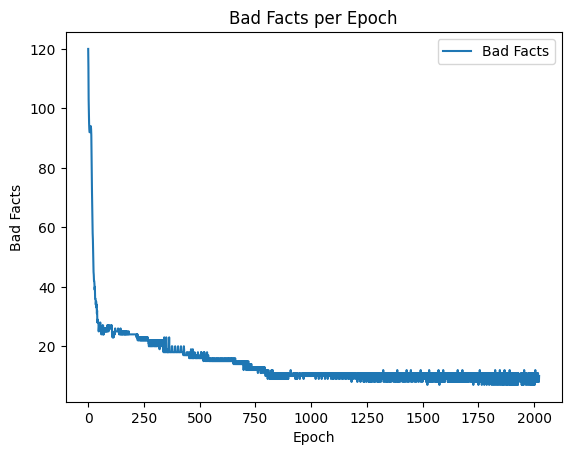

Accuracy: 1.0
Weights saved [[ 5.38551583e+00  2.94596434e+00  4.91100741e+00 -9.90542995e-03]
 [-1.16229342e+00 -3.11791173e+00  1.18106250e+01 -2.66754209e+00]
 [-5.71732475e+00 -2.11538311e+00 -1.08277321e+01  1.59814933e+00]
 [-3.09786840e+00 -1.35504646e+00 -8.37667139e+00  1.93967495e+00]] [[ 3.17278421  0.63889794 -4.32452395]
 [ 0.73830862  1.15801895 -2.73986937]
 [ 3.3631108   3.91301183 -5.21434483]
 [-2.76554218  3.73144659  5.65735912]]


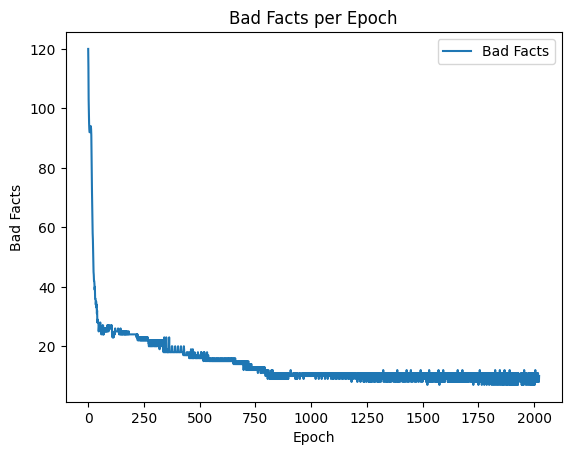

In [17]:
init()
print("shuffle_seed:",shuffle_seed)
train()
accuracy = test()

print("Accuracy:",accuracy)
save_weights()

## load weights and test against training dataset

Weights loaded [[ 5.38551583e+00  2.94596434e+00  4.91100741e+00 -9.90542995e-03]
 [-1.16229342e+00 -3.11791173e+00  1.18106250e+01 -2.66754209e+00]
 [-5.71732475e+00 -2.11538311e+00 -1.08277321e+01  1.59814933e+00]
 [-3.09786840e+00 -1.35504646e+00 -8.37667139e+00  1.93967495e+00]] [[ 3.17278421  0.63889794 -4.32452395]
 [ 0.73830862  1.15801895 -2.73986937]
 [ 3.3631108   3.91301183 -5.21434483]
 [-2.76554218  3.73144659  5.65735912]]
Accuracy: 1.0


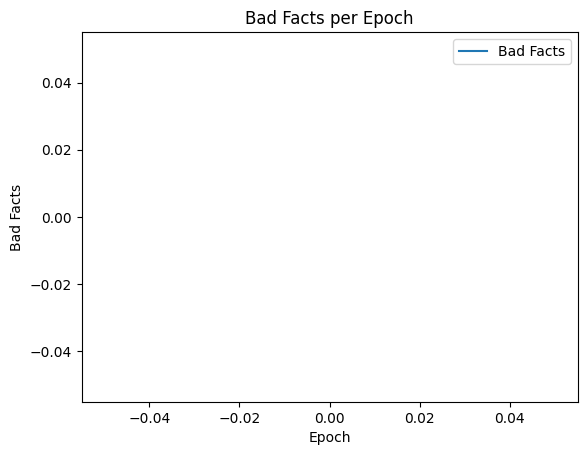

In [15]:
init()
load_weights()
accuracy = test()
print("Accuracy:",accuracy)

# Default parameter experiment

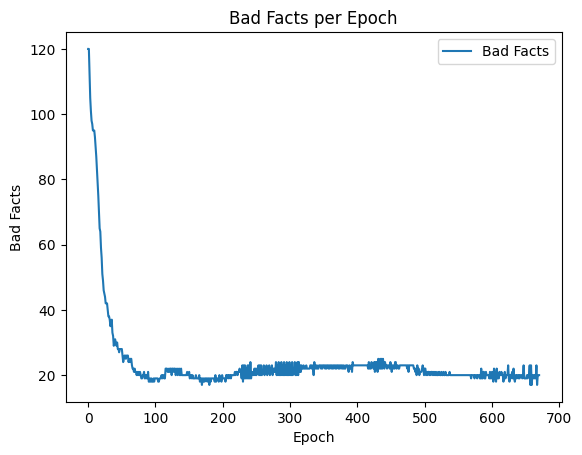

Accuracy: 1.0
Accuracies: [1.         0.93333333 1.        ]
Mean accuracy: 0.9777777777777779


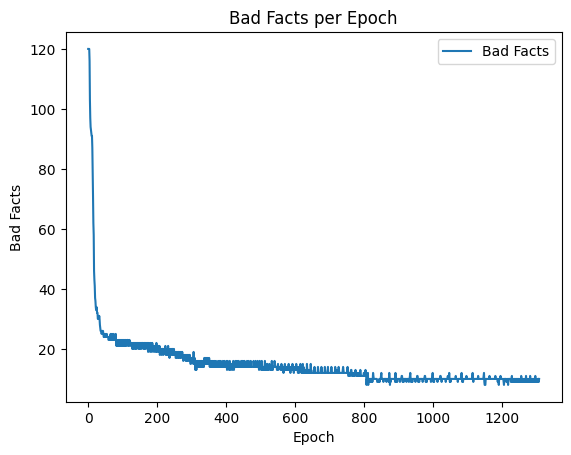

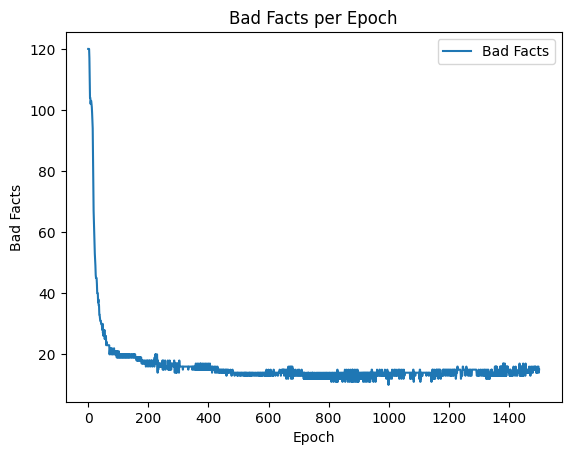

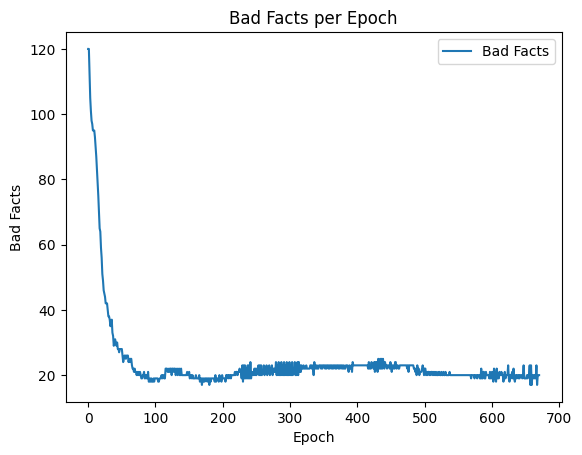

In [25]:
seeds = [292882, 374521, 389998]

accuracies = np.zeros(len(seeds))

for i in range(len(seeds)):
    init(p_seed=seeds[i], layer0_size=4, layer1_size=4, layer2_size=3, p_update_graph_live=True, p_update_graph_intervals=50, p_error_threshold=0.2, p_learning_rate=0.2, p_layer_1_dropout_prob=0.0, p_layer1_activation_function="sigmoid", p_layer2_activation_function="softmax")
    train()
    accuracies[i] = test()
    print("Accuracy:",accuracies[i])
print("Accuracies:",accuracies)
print("Mean accuracy:",np.mean(accuracies))

# Hyperparameter tuning using grid search

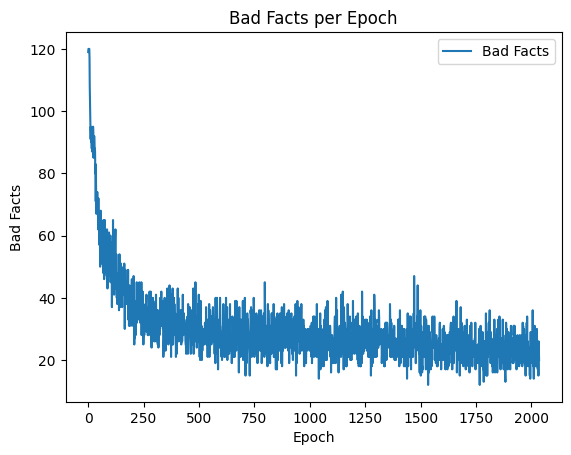

time: 149.66899871826172 epochs: 2036.0 accuracy: 1.0


In [ ]:
# hyperparameter tuning
seeds = [292882, 374521, 389998]

best_mean_accuracy = 0
best_hyperparameters = None

results_per_iter = []


for layer1_size in [2,4,8]:
    for learning_rate in [0.1,0.2,0.3]:
        for error_threshold in [0.1,0.2,0.3]:
            for layer_1_dropout_prob in [0.0,0.1,0.2,0.3]:
                for layer1_activation_function in ["sigmoid","tan_h"]:
                    for layer2_activation_function in ["sigmoid","tan_h","softmax"]:
                        accuracies = np.zeros(len(seeds))
                        epochs = np.zeros(len(seeds))
                        times = np.zeros(len(seeds))
                        for i,seed in enumerate(seeds):
                            #time it
                            start = time.time()
                            init(p_seed=seed, layer0_size=4, layer1_size=layer1_size, layer2_size=3, p_update_graph_live=False, p_update_graph_intervals=5000, p_error_threshold=error_threshold, p_learning_rate=learning_rate, p_layer_1_dropout_prob=layer_1_dropout_prob, p_layer1_activation_function=layer1_activation_function, p_layer2_activation_function=layer2_activation_function)
                            train()
                            accuracies[i] = test()
                            epochs[i] = len(bad_facts_per_epoch)
                            times[i] = time.time()-start
                            print("time:",times[i],"epochs:",epochs[i],"accuracy:",accuracies[i])
                        mean_accuracy = np.mean(accuracies)
                        mean_epochs = np.mean(epochs)
                        mean_time = np.mean(times)
                        
                        print("layer1_size:",layer1_size,"learning_rate:",learning_rate,"error_threshold:",error_threshold,"layer_1_dropout_prob:",layer_1_dropout_prob,"layer1_activation_function:",layer1_activation_function,"layer2_activation_function:",layer2_activation_function,"mean_accuracy:",mean_accuracy,"mean_epochs:",mean_epochs,"mean_time:",mean_time)
                        results_per_iter.append((layer1_size, learning_rate, error_threshold, layer_1_dropout_prob, layer1_activation_function, layer2_activation_function, mean_accuracy, mean_epochs, mean_time))
result_df = pd.DataFrame(results_per_iter, columns=["layer1_size", "learning_rate", "error_threshold", "layer_1_dropout_prob", "layer1_activation_function", "layer2_activation_function", "mean_accuracy", "mean_epochs", "mean_time"])
result_df.sort_values(by="mean_accuracy",ascending=False,inplace=True)
result_df.to_csv("hyperparameter_tuning.csv")

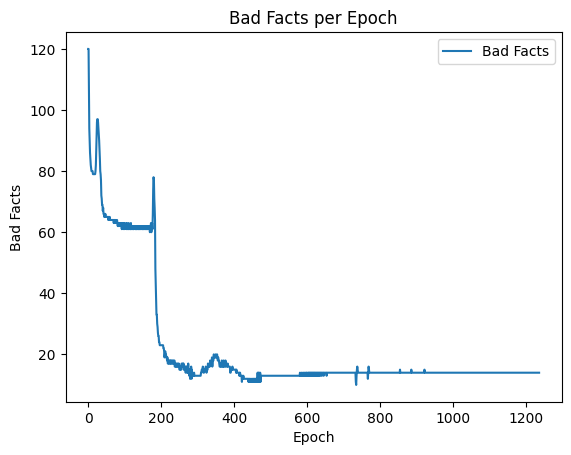

accuracies are equal True
results are equal: True


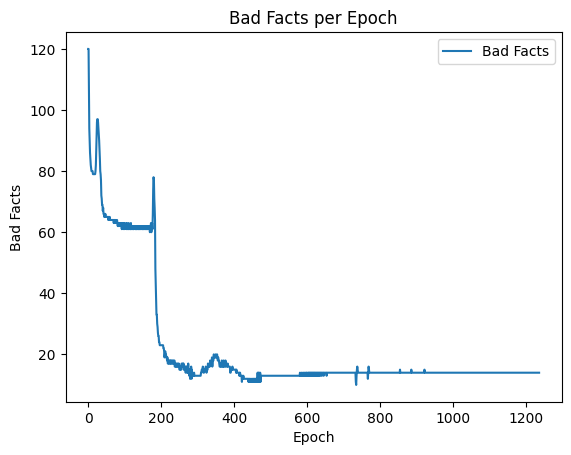

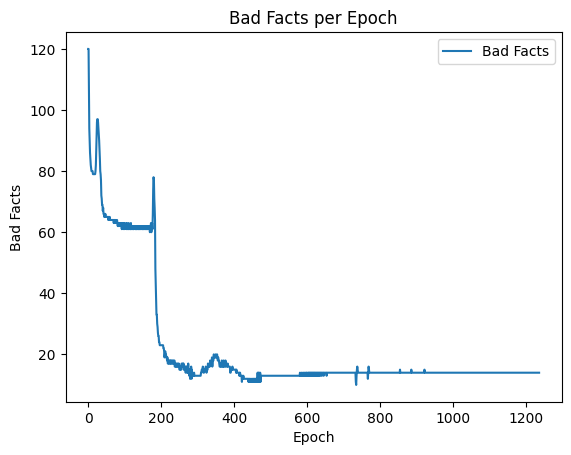

In [24]:
# seed test

seed = 50

results_per_iter = []
bad_facts_per_epoch_per_iter = []

for i in range(2):
    init(p_seed=seed, layer0_size=4, layer1_size=4, layer2_size=3, p_update_graph_live=True, p_update_graph_intervals=50, p_error_threshold=0.2, p_learning_rate=0.2, p_layer_1_dropout_prob=0.0, p_layer1_activation_function="sigmoid", p_layer2_activation_function="softmax")
    
    train()
    accuracy = test()
    results_per_iter.append(bad_facts_per_epoch.copy())

print("accuracies are equal", np.array_equal(results_per_iter[0], results_per_iter[1]))
print("results are equal:", np.array_equal(results_per_iter[0], results_per_iter[1]))